In [1]:
import torch
import detectron2
#from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
from skimage.exposure import equalize_adapthist
import pandas as pd
from fastcore.all import *

setup_logger()

<Logger detectron2 (DEBUG)>

In [31]:
# class ImageEqualize:
#     def __init__(self, clip_limit, difference):
#         self._clip_limit = clip_limit
#         self._difference = difference
# 
#     def equalize(self, img):
#         img = np.array(img)
#         eimg = equalize_adapthist(img, clip_limit=self._clip_limit)
# 
#         if self._difference:
#             img = img - eimg
#             img = img - img.min()
#             img = img / img.max()
#         else:
#             return eimg
# 
#     def __call__(self, image, target):
#         return self.equalize(image), target
MODELS = "./model_permodel"
MODEL_CLASS = "./output2/"
models =  os.listdir(MODELS)

classmap = {'1': 'shsy5y','2':   'astro' , '3' : 'cort'}
classmap [ str(1)]
dataDir= ('C:/kaggletemp/sartorius-cell-instance-segmentation/')
# train_files = os.listdir( os.path.join(dataDir,'train'))
# train_files = [os.path.join(dataDir,'train',x) for x in train_files ]
im =  os.listdir(  )

train_data = pd.read_csv(os.path.join(dataDir,'train.csv') )
data = { 'img' : im }#, 'mask' : ms}
df= pd.DataFrame(data= data)

# merge types:

df['id']  = df.img.map(lambda a:  os.path.split(a)[1].split(".png")[0])
df['type'] = df.id.map(aux_train.set_index('id').cell_type )
df.head()

NameError: name 'tf' is not defined

In [3]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml" ))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.WEIGHTS = os.path.join('./output2', "model_final.pth")
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)
THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]

predictor_class = DefaultPredictor(cfg)

In [4]:
cfg_astro = get_cfg()
cfg_astro.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml" ))
cfg_astro.INPUT.MASK_FORMAT='bitmask'
cfg_astro.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg_astro.MODEL.WEIGHTS = os.path.join('./model_permodel', "model_astro.pth")
cfg_astro.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg_astro)
THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]

predictor_astro = DefaultPredictor(cfg_astro)


In [5]:
cfg_cort = get_cfg()
cfg_cort.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml" ))
cfg_cort.INPUT.MASK_FORMAT='bitmask'
cfg_cort.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg_cort.MODEL.WEIGHTS = os.path.join('./model_permodel', "model_cort.pth")
cfg_cort.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg_cort)
THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]

predictor_cort = DefaultPredictor(cfg_cort)


In [6]:
cfg_shsy5y = get_cfg()
cfg_shsy5y.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml" ))
cfg_shsy5y.INPUT.MASK_FORMAT='bitmask'
cfg_shsy5y.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg_shsy5y.MODEL.WEIGHTS = os.path.join('./model_permodel', "model_shsy5y.pth")
cfg_shsy5y.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg_shsy5y)
THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]

predictor_shsy5y= DefaultPredictor(cfg_shsy5y)


In [7]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int)
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

In [8]:
df = pd.read_csv( os.path.join( dataDir ,"train.csv") )
df = df[['id','cell_type']]  .groupby('id').first().reset_index()

classid = {'shsy5y': 1, 'astro' :2, 'cort': 3}
predictors = {'shsy5y': predictor_shsy5y,
             'astro' :predictor_astro,
             'cort': predictor_cort}

df['classid'] = df['cell_type'].map(classid)
print( df.head(10) )
df.groupby('classid').count()

             id cell_type  classid
0  0030fd0e6378    shsy5y        1
1  0140b3c8f445     astro        2
2  01ae5a43a2ab      cort        3
3  026b3c2c4b32      cort        3
4  029e5b3b89c7      cort        3
5  0323e81d23d9      cort        3
6  03b27b381a5f      cort        3
7  042c17cd9143    shsy5y        1
8  042dc0e561a4    shsy5y        1
9  04928f0866b0      cort        3


,id,cell_type
classid,,
1,155,155
2,131,131
3,320,320


In [9]:
from pathlib import Path
def get_class(fn, predictorx):
    im = cv2.imread(fn)
    pred =  predictorx(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    return pred_class

#predictor = DefaultPredictor(cfg)
# img = os.path.join(dataDir,  'train',df.id[1] + '.png')
#
# get_masks(img, cfg).cpu()

In [10]:
# ids = []
# for index, rows in df.iterrows():
#     img = os.path.join(dataDir,  'train',rows.id + '.png')
#     classid = get_masks(img, predictor)
#     ids.append(classid.cpu().numpy())


In [49]:
df['class_predicted']= [i +1 for i in ids]
confusion_matrix = pd.crosstab(df['classid'], df['class_predicted'], rownames=['classid'], colnames=['class_predicted'])
print (confusion_matrix)

class_predicted    1    2    3
classid                       
1                155    0    0
2                  0  131    0
3                  0    0  320


180
72
123


array([0, 1], dtype=uint8)

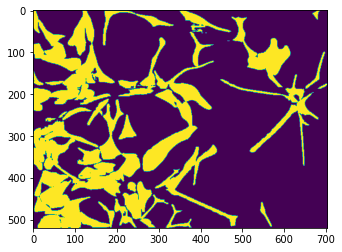

In [23]:
def rle2mask(rle, img_w, img_h):

    ## transforming the string into an array of shape (2, N)
    array = np.fromiter(rle.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1

    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction
    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img = np.asfortranarray(msk_img) ## This is important so pycocotools can handle this object

    return msk_img


ids, masks=[],[]
#test_names = (dataDir/'test').ls()

pathtest = os.path.join(dataDir,"test")
test_names =  os.listdir(pathtest)
test_names = [ os.path.join(pathtest, x) for x in test_names ]
test_names
#THRESHOLDS = [.27,.24,.28]
THRESHOLDS = [.15, .35, .55]
#THRESHOLDS = [.5, .55, .55]

ll = []
for fn in test_names:
    classid = get_class(fn, predictor_class)
    ctype = classmap [ str(classid.cpu().numpy() +1) ]

   # print(ctype)

    predictor = predictors[ctype]
    encoded_masks = get_masks(fn, predictor)
    print(len ( encoded_masks))
    for enc in encoded_masks:
        path, file = os.path.split(fn)
        id =  file.split(".png")[0]
  #      print(id)
        ids.append(id)
        masks.append(enc)
       # x = [ x + rle]
    #print(masks)
    ll.append( (id,len ( encoded_masks) )  )

pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()
xx = pd.DataFrame({'id':ids, 'predicted':masks})
idx = xx.id.unique()

mx =[  rle2mask(x, 704, 520)  for x in  xx[ xx['id'] == idx[2]].predicted ]
mx = sum(mx)
plt.imshow(mx)
np.unique(mx)

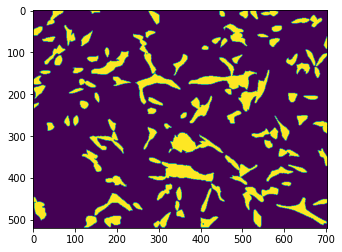

In [24]:
mx =[  rle2mask(x, 704, 520)  for x in  xx[ xx['id'] == idx[0]].predicted ]
mx = sum(mx)
plt.imshow(mx)

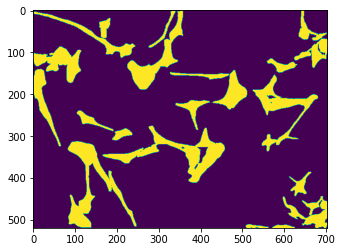

In [25]:
mx =[  rle2mask(x, 704, 520)  for x in  xx[ xx['id'] == idx[1]].predicted ]
mx = sum(mx)
plt.imshow(mx)


# get the best threshould


In [28]:
# pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
# pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,314702 69 315406 69 316110 69 316814 69 317518...
1,7ae19de7bc2a,22612 57 23316 57 24020 57 24724 57 25428 57 2...
2,7ae19de7bc2a,716 36 1420 36 2124 36 2828 36 3532 36 3593 1 ...
3,7ae19de7bc2a,282707 16 282725 1 282729 33 283411 15 283435 ...
4,7ae19de7bc2a,310626 92 311330 27 311366 56 312034 25 312073...


In [18]:
def rles_to_mask(encs, shape):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    if type(encs)==float:
        return img
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union

    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

from tqdm.auto import tqdm
def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    # ious = [
    #     compute_iou(rles_to_mask(truth,shape), rles_to_mask(pred,shape))
    #         for truth, pred in tqdm(zip(truths, preds))
    # ]
    ious = compute_iou(truths,preds)
    if verbose:
        print(ious[0].shape)
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


SyntaxError: invalid syntax (Temp/ipykernel_20356/1692376965.py, line 5)

In [28]:
thr = .5
class_id = { 'shsy5y' : 1, 'astro':2, 'cort' : 3 }
width = 704
height = 520
shape = [height,width]
def get_masks_tothr(fn, predictor,thr):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= thr #THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int)
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append((mask))
    res = sum(mask)
    return res

def get_iou_trh(thr,ctype):
    masks = []
    preds = []
    for index, row in  tqdm(df[df['type']==ctype].iterrows(), total = df[df['type']==ctype].shape[0]) :   #df[df['type']==ctype].iterrows():
        #predx = sum([  infer(model,read_image( row['img'] , mask = False) )[0]  for model in models]) / len(models)
        predictor = predictors[ctype]
        predx = get_masks_tothr(fn, predictor, thr)
        predx = predx.cpu().numpy()
        #predx = tf.squeeze(predx).numpy()
        #predx = predx.astype(np.uint8)
        #nclass = infer(models[0],read_image( row['img'] , mask = False)  )[1]
        mask = read_mask(row['mask'])
        mask = tf.squeeze(mask).numpy()
        mask = mask > 0
        mask = mask.astype(np.uint8)
        #ctype = row['type']

        masks.append(mask)
        preds.append(predx)
    return  iou_map(masks,preds)

def plot_thr(ones,thrs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = thrs
    y = ones
    line, = ax.plot(x, y)

    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]

    def annot_max(x,y, ax=None):
        xmax = x[np.argmax(y)]
        ymax = max(y)
        text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

    annot_max(x,y)

    ax.set_ylim(0,1.5 * max(y))
    plt.show()


def get_best_tr(ctype):
    thrs = np.arange(0,1,.1)
    ones = []
    for i in np.arange(0,1,.1):
       ones.append( get_iou_trh(i,ctype))

    plot_thr(ones, thrs)


def plot_thr(ones,thr):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = thrs
    y = ones
    line, = ax.plot(x, y)

    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]

    def annot_max(x,y, ax=None):
        xmax = x[np.argmax(y)]
        ymax = max(y)
        text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

    annot_max(x,y)

    ax.set_ylim(0,1.5 * max(y))
    plt.show()


In [30]:
ctyp

'astro'

In [33]:
predictors = {'shsy5y': "a",
             'astro' : "b",
             'cort': "c"}

predictors[ctype]

'b'